# Bands Workflows


In [1]:
from local_module import load_temp_profile
from aiida import engine, orm, plugins

data = load_temp_profile(add_sssp=True)
data

AiiDALoaded(profile=Profile<uuid='8ccf0779ed3c423b84c417237baa8b72' name='temp_profile'>, computer=<Computer: local_direct (localhost), pk: 1>, pw_code=<Code: Remote code 'pw.x' on local_direct, pk: 1, uuid: 8d266e0b-e82e-4b5b-9dbd-315bc2f0537a>, pseudos=SsspFamily<1>, si=<StructureData: uuid: d28d06f6-9f46-418e-90cf-f1689920e0b4 (pk: 87)>)

In [8]:
PwBandsWorkChain = plugins.WorkflowFactory("quantumespresso.pw.bands")
builder = PwBandsWorkChain.get_builder_from_protocol(
    code=data.pw_code, structure=data.si, protocol="fast"
)
builder

Process class: PwBandsWorkChain
Inputs:
bands:
  metadata: {}
  pw:
    code: pw.x code on local computer
    metadata:
      options:
        max_wallclock_seconds: 43200
        resources:
          num_machines: 1
        stash: {}
        withmpi: true
    parameters:
      CONTROL:
        calculation: scf
        etot_conv_thr: 0.0002
        forc_conv_thr: 0.001
        tprnfor: true
        tstress: true
      ELECTRONS:
        conv_thr: 8.0e-10
        electron_maxstep: 80
        mixing_beta: 0.4
      SYSTEM:
        degauss: 0.01
        ecutrho: 240.0
        ecutwfc: 30.0
        nosym: false
        occupations: smearing
        smearing: cold
    pseudos:
      Si: ''
bands_kpoints_distance: 0.1
clean_workdir: true
metadata: {}
nbands_factor: 3.0
relax:
  base:
    kpoints_distance: 0.5
    kpoints_force_parity: false
    metadata: {}
    pw:
      code: pw.x code on local computer
      metadata:
        options:
          max_wallclock_seconds: 43200
          resour

In [3]:
result = engine.run_get_node(builder)
result

09/21/2022 12:59:31 PM <96220> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [104|PwBandsWorkChain|run_relax]: launching PwRelaxWorkChain<106>
09/21/2022 12:59:31 PM <96220> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [106|PwRelaxWorkChain|run_relax]: launching PwBaseWorkChain<109>
09/21/2022 12:59:34 PM <96220> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [109|PwBaseWorkChain|run_process]: launching PwCalculation<114> iteration #1
09/21/2022 12:59:48 PM <96220> aiida.scheduler.direct: [WARNING] Unrecognized job_state '?' for job id 96945
09/21/2022 12:59:48 PM <96220> aiida.scheduler.direct: [WARNING] Unrecognized job_state '?' for job id 96949
09/21/2022 12:59:56 PM <96220> aiida.scheduler.direct: [WARNING] Unrecognized job_state '?' for job id 97156
09/21/2022 01:00:06 PM <96220> aiida.scheduler.direct: [WARNING] Unrecognized job_state '?' for job id 97483
09/21/2022 01:00:51 PM <96220> aiida.scheduler.direct: [WARNIN

ResultAndNode(result={'primitive_structure': <StructureData: uuid: 617e9b20-892f-4dc5-adb8-a91daa78965f (pk: 138)>, 'seekpath_parameters': <Dict: uuid: 9d4668dd-3dc4-43d2-a003-b4311393efa1 (pk: 136)>, 'scf_parameters': <Dict: uuid: 0d8fc844-aa38-4b36-a32b-aef57a505c92 (pk: 152)>, 'band_parameters': <Dict: uuid: deae5042-e9f1-4db8-a31e-d0eff942b0d9 (pk: 163)>, 'band_structure': <BandsData: uuid: a66d6e53-afbb-4a2c-a74f-8a8135b55886 (pk: 161)>}, node=<WorkChainNode: uuid: e295fd0e-42e2-41e5-a99c-37461cb9fc67 (pk: 104) (aiida.workflows:quantumespresso.pw.bands)>)

In [9]:
%verdi process status 104

PwBandsWorkChain<104> Finished [0] [7:results]
    ├── PwRelaxWorkChain<106> Finished [0] [3:results]
    │   ├── PwBaseWorkChain<109> Finished [0] [4:results]
    │   │   ├── create_kpoints_from_distance<110> Finished [0]
    │   │   └── PwCalculation<114> Finished [0]
    │   └── PwBaseWorkChain<123> Finished [0] [4:results]
    │       ├── create_kpoints_from_distance<124> Finished [0]
    │       └── PwCalculation<128> Finished [0]
    ├── seekpath_structure_analysis<135> Finished [0]
    ├── PwBaseWorkChain<142> Finished [0] [4:results]
    │   ├── create_kpoints_from_distance<143> Finished [0]
    │   └── PwCalculation<147> Finished [0]
    └── PwBaseWorkChain<155> Finished [0] [4:results]
        └── PwCalculation<158> Finished [0]


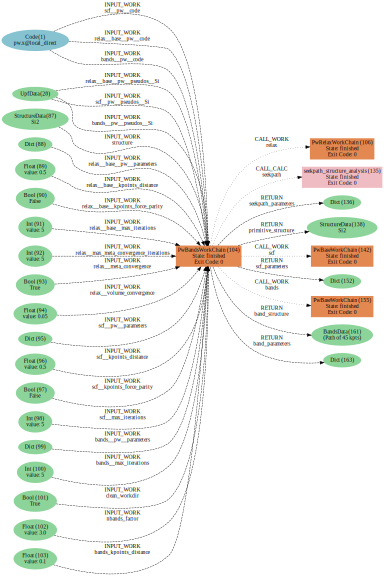

In [7]:
from aiida.tools.visualization import Graph
graph = Graph(graph_attr={"rankdir": "LR", "size": "8!,8!"})
graph.add_incoming(result.node, annotate_links="both")
graph.add_outgoing(result.node, annotate_links="both")
graph.graphviz